In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
from dotenv import load_dotenv
from polygon import RESTClient
import json

load_dotenv() 


API_KEY = os.getenv("API_KEY")
client = RESTClient(api_key=API_KEY)


In [4]:
def get_stock_data(ticker, multiplier, timespan, from_, to, limit):
    aggs = []
    for a in client.list_aggs(ticker=ticker, multiplier=multiplier, timespan=timespan, from_=from_, to=to, limit=limit):
        aggs.append(a)
    df = pd.DataFrame(aggs)
    df['Date'] = df['timestamp'].apply(lambda x: pd.to_datetime(x*1000000))
    df = df.drop(columns=['otc'])
    df = df.drop(columns=['timestamp'])
    return df

df = get_stock_data('AAPL', 4, 'hour', '2024-01-01', '2024-04-02', 1000)
df

MaxRetryError: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/AAPL/range/4/hour/2024-01-01/2024-04-02?limit=1000 (Caused by ResponseError('too many 429 error responses'))

### William Fractals

In [ ]:
def calculate_fractals(df):
    highs = df['high']
    lows = df['low']
    
    # Identify potential fractals
    is_fractal_high = (highs.shift(1) < highs) & (highs.shift(-1) < highs)
    is_fractal_low = (lows.shift(1) > lows) & (lows.shift(-1) > lows)
    
    df['fractal_highs'] = np.where(is_fractal_high, highs, np.nan)
    df['fractal_lows'] = np.where(is_fractal_low, lows, np.nan)
    
    return df
# Calculate fractals

df = calculate_fractals(df)
df

,open,high,low,close,volume,vwap,transactions,Date,fractal_highs,fractal_lows
0,493.74,495.20,493.74,494.72,2295,494.7773,101,2024-01-02 09:00:00,NaN,NaN
1,494.85,494.85,494.83,494.83,726,494.9053,40,2024-01-02 09:01:00,NaN,NaN
2,495.25,495.25,494.95,495.22,1008,495.1969,24,2024-01-02 09:02:00,NaN,NaN
3,495.28,495.28,495.28,495.28,325,495.2549,18,2024-01-02 09:03:00,NaN,NaN
4,495.28,495.28,495.28,495.28,309,495.2482,18,2024-01-02 09:04:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
765,479.10,479.13,479.10,479.13,806,479.1640,29,2024-01-03 00:54:00,NaN,479.1
766,479.32,479.32,479.30,479.32,1941,479.3121,34,2024-01-03 00:56:00,NaN,NaN
767,479.32,479.32,479.30,479.32,2390,479.3032,43,2024-01-03 00:57:00,NaN,NaN
768,479.30,479.30,479.22,479.22,3698,479.2883,52,2024-01-03 00:58:00,NaN,NaN


### Visualize

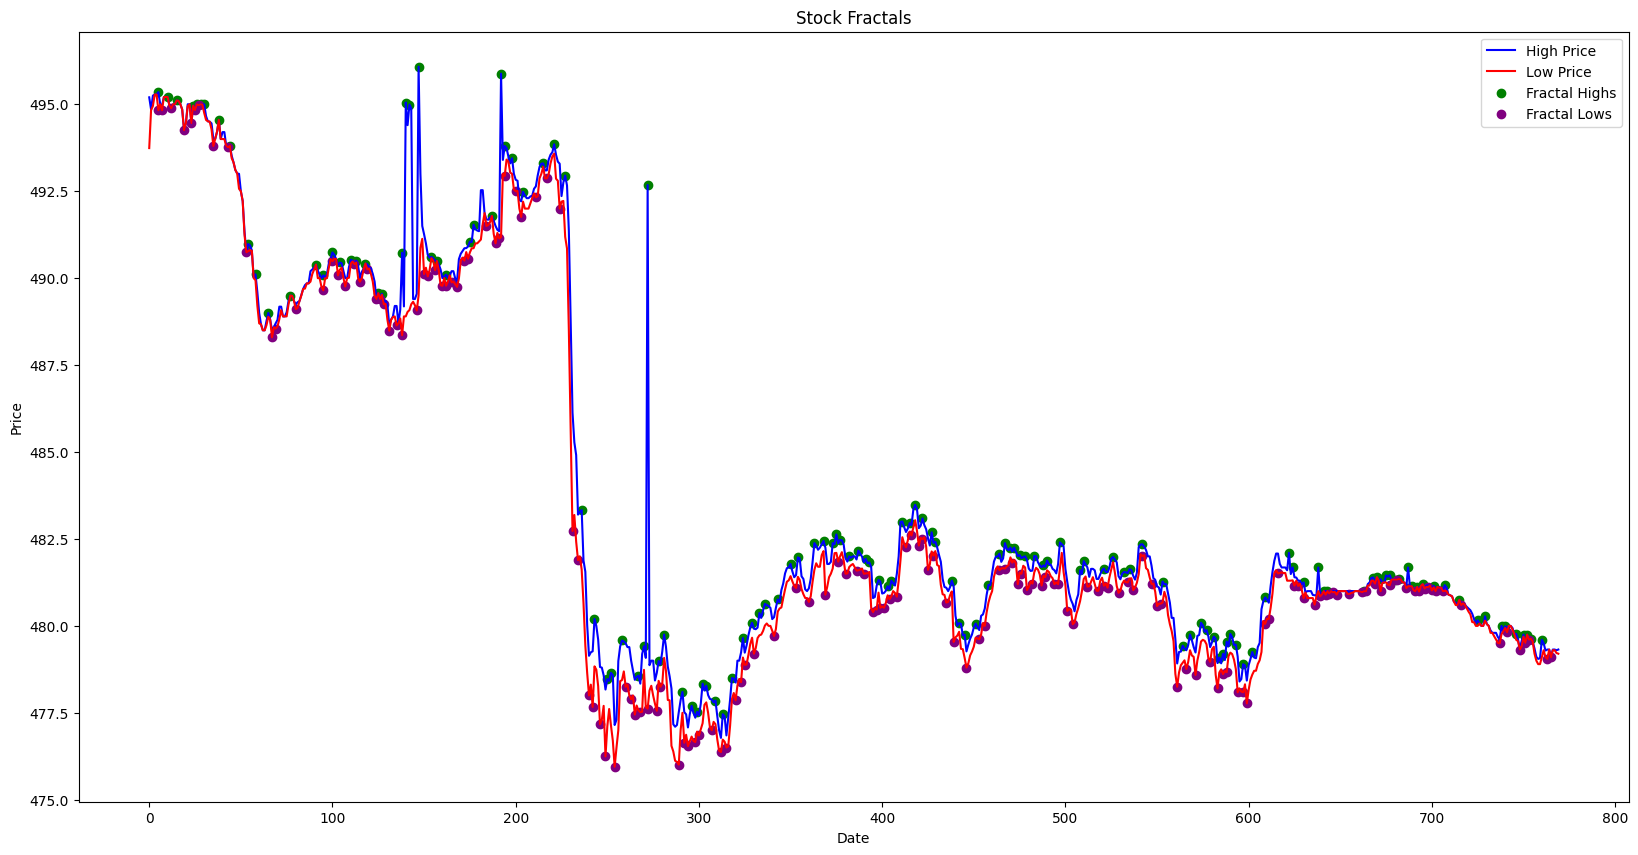

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df['high'], label='High Price', color='blue')
plt.plot(df['low'], label='Low Price', color='red')
plt.scatter(df.index, df['fractal_highs'], color='green', label='Fractal Highs')
plt.scatter(df.index, df['fractal_lows'], color='purple', label='Fractal Lows')
plt.title('Stock Fractals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Fibonacci Retracement

In [ ]:
def fibonacci_retracement(df):
    max_fractal_high = df['fractal_highs'].tail(120).max()
    min_fractal_low = df['fractal_lows'].tail(120).min()
    
    # Calculate the different etween high and low
    price_range = max_fractal_high - min_fractal_low
    
    #calculate retracement levels
    retracement_minus_23_6 = max_fractal_high + 0.236 * price_range
    retracement_0 = max_fractal_high
    retracement_23_6 = max_fractal_high - 0.236 * price_range
    retracement_38_2 = max_fractal_high - 0.382 * price_range
    retracement_50 = max_fractal_high - 0.5 * price_range
    retracement_61_8 = max_fractal_high - 0.618 * price_range
    retracement_78_6 = max_fractal_high - 0.786 * price_range
    retracement_100 = min_fractal_low
    
    # Create dict tos tore levels
    retracement_levels = {
        '-0.236': retracement_minus_23_6,
        '0': retracement_0,
        '0.236': retracement_23_6,
        '0.382': retracement_38_2,
        '0.5': retracement_50,
        '0.618': retracement_61_8,
        '0.786': retracement_78_6,
        '1': retracement_100,
    }
    
    return retracement_levels

retracement_levels = fibonacci_retracement(df)

#display levels
for level, price in retracement_levels.items():
    print(f'{level}: {price}')

-0.236: 482.30065640000004
0: 481.68
0.236: 481.0593436
0.382: 480.6753782
0.5: 480.36505
0.618: 480.0547218
0.786: 479.6128986
1: 479.0501


### Visualize Fib

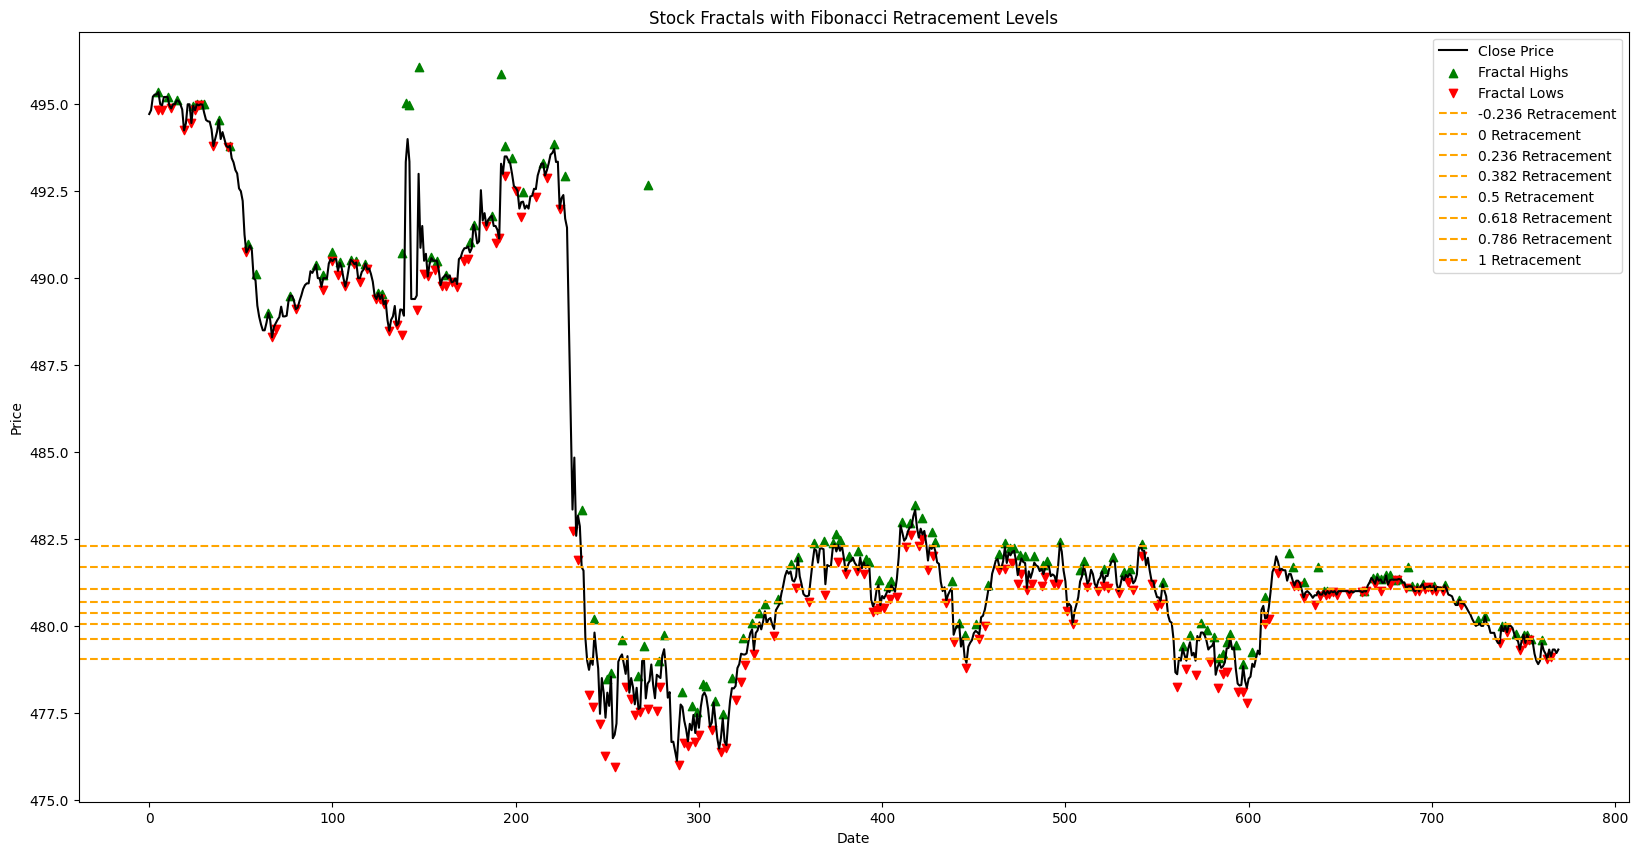

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df['close'], label='Close Price', color='black')
plt.scatter(df.index, df['fractal_highs'], marker='^', color='green', label='Fractal Highs')
plt.scatter(df.index, df['fractal_lows'], marker='v', color='red', label='Fractal Lows')

for level, price in retracement_levels.items():
    plt.axhline(y=price, color='orange', linestyle='--', label=f'{level} Retracement')
plt.title('Stock Fractals with Fibonacci Retracement Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show() 
